In [1]:
from geodude.fonts import font_to_polygons
from geodude import fonts_root

%load_ext autoreload
%autoreload 2

In [9]:
font_paths = {f.stem:f for f in fonts_root.glob("**/*.ttf")}

In [10]:
font_path = font_paths['EBGaramond-Bold']

In [24]:
from fontTools.pens.recordingPen import RecordingPen
from fontTools.pens.flattenPen import FlattenPen

def extract_glyph_points(font_path, glyph_name, tolerance=0.1):
    """
    Extracts the glyph points from the specified font file.

    Args:
        font_path (str): The path to the font file.
        glyph_name (str): The name of the glyph to extract.
        tolerance (float): The tolerance for the approximation of the Bezier curves. Lower values give more accurate approximations.

    Returns:
        list: A list of (x, y) tuples representing the points of the glyph.
    """
    from fontTools.ttLib import TTFont

    font = TTFont(font_path)
    glyph_set = font.getGlyphSet()
    glyph = glyph_set[glyph_name]

    recording_pen = RecordingPen()
    flatten_pen = FlattenPen(recording_pen, tolerance)

    glyph.draw(flatten_pen)

    points = []
    for command, args in recording_pen.value:
        if command in ["moveTo", "lineTo"]:
            points.append(args[0])
        elif command == "qCurveTo":
            points.extend(args)

    return points


ModuleNotFoundError: No module named 'fontTools.pens.flattenPen'

In [35]:
from fontTools.ttLib import TTFont
from fontTools.pens.recordingPen import RecordingPen
from geodude.line import bezier_func
import numpy as np

glyph_name='A'
n_points=100

font = TTFont(font_path)
glyph_set = font.getGlyphSet()
glyph = glyph_set[glyph_name]

# Draw the glyph with a RecordingPen
pen = RecordingPen()
glyph.draw(pen)

# Get the commands from the pen
commands = pen.value

# Create a list to store the points
points = []

# For each command
for command in commands:
    operation, command_points = command
    # If the command is a curve, use the Bezier function to get the points
    if operation in ['curveTo', 'qCurveTo']:
        bezier = bezier_func(command_points)
        t_values = np.linspace(0, 1, n_points)
        curve_points = bezier(t_values, as_numpy=True)
        points.extend(curve_points)
    # If the command is a line or move, just use the command points
    elif operation in ['lineTo', 'moveTo']:
        points.extend(command_points)

In [49]:
def extract_glyph_points(font_path, glyph_name, n_points=100):
    """
    Extracts the glyph points from the specified font file.
    
    Args:
        font_path (str): Path to the font file.
        glyph_name (str): Name of the glyph to extract.
        n_points (int): Number of points to sample from each curve.
    
    Returns:
        list: A list of subpaths, where each subpath is a list of (x, y) tuples representing the points of the glyph.
    """
    # Load the font and get the glyph
    font = TTFont(font_path)
    glyph_set = font.getGlyphSet()
    glyph = glyph_set[glyph_name]

    # Draw the glyph with a RecordingPen
    pen = RecordingPen()
    glyph.draw(pen)

    # Get the commands from the pen
    commands = pen.value

    # Create a list to store the subpaths
    subpaths = []
    # And a list to store the points of the current subpath
    subpath = []

    # For each command
    for command in commands:
        operation, command_points = command
        # If the command is a curve, use the Bezier function to get the points
        if operation in ['curveTo', 'qCurveTo']:
            bezier = bezier_func(command_points)
            t_values = np.linspace(0, 1, n_points)
            curve_points = bezier(t_values, as_numpy=True)
            subpath.extend(curve_points)
        # If the command is a line or move, just use the command points
        elif operation in ['lineTo', 'moveTo']:
            subpath.extend(command_points)
        # If the command is a closePath, finish the current subpath and start a new one
        elif operation == 'closePath':
            if subpath:
                subpaths.append(subpath)
                subpath = []

    # If there's an open subpath at the end, add it to the list
    if subpath:
        subpaths.append(subpath)

    return subpaths


In [51]:
subpaths = extract_glyph_points(font_path, glyph_name)

# Convert the list of subpaths to a polygon
polygon = Polygon(subpaths[0], subpaths[1:])

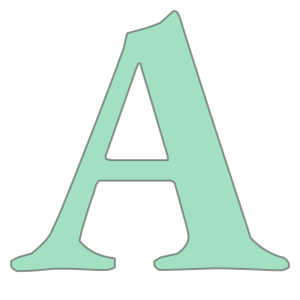

In [52]:
polygon

In [46]:
np.array(points)[2:]

array([[ 10.69850015,  -4.8583818 ],
       [ 10.40006122,  -4.71635547],
       [ 10.1046832 ,  -4.57392103],
       ...,
       [262.71553923, 287.00163249],
       [262.85817774, 287.00040812],
       [263.        , 287.        ]])

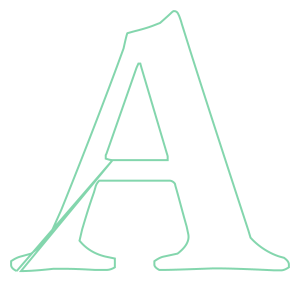

In [47]:
Polygon(np.array(points)[2:]).boundary

In [21]:
from fontTools.ttLib import TTFont
from fontTools.pens.recordingPen import RecordingPen
from fontTools.pens.pointPen import PointPen
from shapely.geometry import Polygon

# Choose a character to test
character = 'A'

 # Load the font file
font = TTFont(font_path)

# Get the glyph set from the font
glyph_set = font.getGlyphSet()

# Get the glyph for the requested character
glyph = glyph_set[character]

# Draw the glyph using a recording pen to collect the contours
pen = PointPen()
glyph.draw(pen)

# Convert the glyph contours to polygons
polygons = []
for contour in pen.value:
    polygon = Polygon(contour[1][0])
    polygons.append(polygon)

TypeError: 'int' object is not iterable

In [23]:
pen.value

[('moveTo', ((22, -5),)),
 ('qCurveTo', ((11, -5), (-4, 2), (-4, 11))),
 ('qCurveTo', ((-4, 21), (9, 30), (20, 33))),
 ('qCurveTo', ((49, 41), (92, 75), (103, 100))),
 ('qCurveTo', ((128, 156), (172, 265), (214, 372), (256, 483), (277, 540))),
 ('qCurveTo', ((292, 581), (300, 618), (302, 621))),
 ('qCurveTo', ((320, 626), (352, 634), (370, 641))),
 ('qCurveTo', ((388, 648), (413, 670), (419, 676))),
 ('qCurveTo', ((423, 679), (431, 680), (435, 673))),
 ('qCurveTo', ((438, 667), (443, 654), (445, 646))),
 ('qCurveTo', ((466, 579), (510, 440), (555, 302), (599, 167), (620, 103))),
 ('qCurveTo', ((626, 83), (651, 55), (683, 39), (703, 33))),
 ('qCurveTo', ((714, 30), (727, 21), (727, 12))),
 ('qCurveTo', ((727, 5), (715, -3), (707, -3))),
 ('qCurveTo', ((687, -3), (628, 0), (568, 2), (545, 2))),
 ('qCurveTo', ((526, 2), (471, 0), (415, -2), (395, -2))),
 ('qCurveTo', ((386, -2), (373, 5), (373, 12))),
 ('qCurveTo', ((373, 21), (387, 31), (397, 33))),
 ('qCurveTo', ((434, 41), (468, 67), (

In [ ]:
import numpy as np
from shapely import LineString, MultiLineString


def bezier_func(points):
    """
    Create a Bezier curve function given a list of control points.

    Arguments:
    points -- a list of tuples representing the (x, y) coordinates of the control points

    Returns:
    A function that takes a 1D array of values t between 0 and 1 and returns a 2D array of (x, y) coordinates on the curve.
    """
    # Define the De Casteljau's algorithm to recursively subdivide the control points
    def de_casteljau(t, points):
        if len(points) == 1:
            return points[0]
        else:
            x_coords, y_coords = zip(*points)
            new_x_coords = (1 - t) * np.array(x_coords[:-1]) + t * np.array(x_coords[1:])
            new_y_coords = (1 - t) * np.array(y_coords[:-1]) + t * np.array(y_coords[1:])
            new_points = list(zip(new_x_coords, new_y_coords))
            return de_casteljau(t, new_points)

    # Define the Bezier curve function that calls the De Casteljau's algorithm
    def evaluate_bezier(t, as_numpy: bool = False):
        """
        Evaluate the Bezier curve at a point t between 0 and 1.

        Arguments:
        t -- a 1D array of values between 0 and 1

        Returns:
        A 2D array of (x, y) coordinates on the curve at the given values of t.
        """
        pts = np.array([de_casteljau(ti, points) for ti in t])
        if as_numpy:
            return pts
        else:
            return LineString(pts)

    return evaluate_bezier

In [11]:
# Choose a character to test
character = 'A'

# Use the function to get the polygons
polygons = font_to_polygons(font_path, character)

# Print the polygons
for i, polygon in enumerate(polygons):
    print(f"Polygon {i}: {polygon}")

ValueError: could not convert string to float: 'm'